# Zebrafish - Affine Transformation

## Import Libraries

In [1]:
import numpy as np
from PIL import Image
import imageio
import numpy as np
from dipy.viz import regtools
from dipy.data import fetch_stanford_hardi, read_stanford_hardi
from dipy.data.fetcher import fetch_syn_data, read_syn_data
from dipy.align.imaffine import (transform_centers_of_mass,
                                 AffineMap,
                                 MutualInformationMetric,SSDMetric,
                                 AffineRegistration)
from dipy.align.transforms import (TranslationTransform2D,
                                   RigidTransform2D,RotationTransform2D,
                                   AffineTransform2D)


import scipy.ndimage 
#
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


plt.style.use("fivethirtyeight")

C:\Users\mchiv\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 1. Read Images

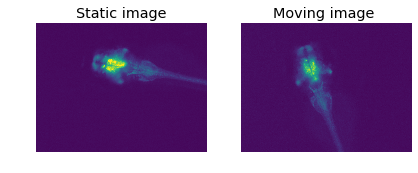

In [2]:
"""
Read image
"""
def read_image(file):
    image = imageio.imread(file)
    return image

"""
Show image
"""
def show_image(image,title=""):
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()
    
    
"""
Plot two images
"""
def plot_two_images(static, moving, text=""):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(static)
    plt.title("Static image")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.imshow(moving)
    plt.title("Moving image" + " " + text)
    plt.axis("off")

    
# image1
image1 = read_image("Image_20449.tif")
image2 = read_image("Image_20450.tif")

plot_two_images(image1, image2)


### 2. Threshold Image

Images thresholded at the mean


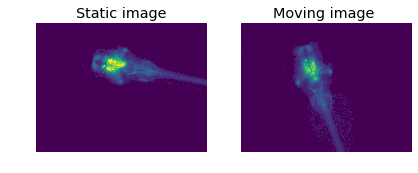

In [3]:
static = np.copy(image1)
moving = np.copy(image2)
## Threshold image
def threshold_image(im):
    im[im<np.mean(im)]=0
    return im

static = threshold_image(static)
moving = threshold_image(moving)

print(f"Images thresholded at the mean")
plot_two_images(static, moving)

### 3. Transform - center of mass of images


Images with center of mass transformed


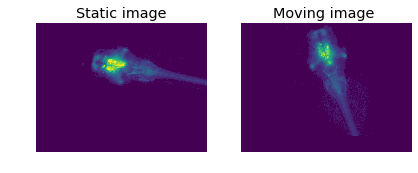

In [4]:
c_of_mass = transform_centers_of_mass(static, None, moving, None)
print("Images with center of mass transformed")
transformed = c_of_mass.transform(moving)

moving = np.copy(transformed)
plot_two_images(static, transformed)

### 4. Initialize the Metric

In [5]:
import scipy.ndimage as ndimage


def ssd(arr1,arr2):
    """ Compute the sum squared difference metric """
    x = min(arr1.shape[0],arr2.shape[0])
    y = min(arr1.shape[1],arr2.shape[1])
    return np.sum((arr1[:x,:y]-arr2[:x,:y])**2)

def apply_rotation(angle, img):
    pivot = scipy.ndimage.center_of_mass(img)
    padX = [img.shape[1] - pivot[0], pivot[0]]
    padY = [img.shape[0] - pivot[1], pivot[1]]
    pad_width = np.array([padY, padX],dtype='i')
    imgP = np.pad(img, pad_width, 'constant')
    imgR = ndimage.rotate(imgP, angle,order=1)
    return imgR

    
def cost_ssd(param,reference_image, target_image):
    # = static, moving
    #transformed = apply_rotation(param,target_image)
    affine_transform = RotationTransform2D()
    
    current_affine = affine_transform.param_to_matrix(param)
    affine_map = AffineMap (current_affine , reference_image.shape, None,
                                      target_image.shape, None )
    transformed = affine_map.transform ( target_image )
    
    
    cost =  ssd(reference_image, transformed)
    print("Param",param,"cost",cost)
    return cost




### 5a. Optimize (Without Dipy, custom optimizer)

In [6]:
from scipy import optimize

initial = [np.rad2deg(1)]

def c(params):
    current_affine = affine_transform.param_to_matrix(params)
    return metric.distance(params)

def trying_params(params):
    """ callback function """
    print("trying_params: " + str(params))

best_params = optimize.fmin_powell(cost_ssd, initial, args = (static,moving), callback=trying_params)
## rotate image
print("Best params",best_params)

Param [57.29577951] cost 368829805225.0645
Param [57.29577951] cost 368829805225.0645
Param [58.29577951] cost 259976774480.0
Param [59.91381351] cost 259976774480.0
Param [58.29577951] cost 259976774480.0
Param [58.91381349] cost 259976774480.0
Param [59.2957795] cost 259976774480.0
Param [59.53184748] cost 259976774480.0
Param [59.67774552] cost 259976774480.0
Param [59.76791547] cost 259976774480.0
Param [59.82364356] cost 259976774480.0
Param [59.85808542] cost 259976774480.0
Param [59.88370847] cost 259976774480.0
trying_params: [59.88370847]
Param [62.47163744] cost 309627038585.67975
Param [59.88370847] cost 259976774480.0
Param [62.47163744] cost 309627038585.67975
Param [55.69635143] cost 259930863960.35156
Param [57.78809286] cost 301949467830.2772
Param [59.88370847] cost 259976774480.0
Param [60.87220935] cost 259976774480.0
Param [61.4831365] cost 259977091665.9307
Param [60.37795891] cost 259976774480.0
Param [60.18917205] cost 259976774480.0
Param [60.07249535] cost 2599

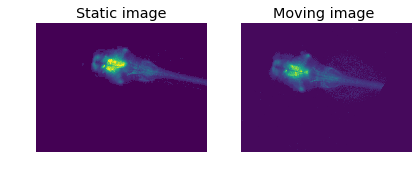

In [7]:
transformed = scipy.ndimage.interpolation.rotate(moving,(best_params),reshape=False)
plot_two_images(static, transformed)

### 5b. Optimize (With SSDMetric - but not optimizer)

In [8]:
from scipy import optimize

initial = [np.rad2deg(1)]
# compute ssd
metric = SSDMetric()
affine_transform = RotationTransform2D()
metric.setup(affine_transform, static, moving,
                              None,
                              None, None)

def c(params):
    current_affine = affine_transform.param_to_matrix(params)
    return metric.distance(params)
 

best_params = optimize.minimize(c, initial, method='L-BFGS-B', tol=1e-6)
## rotate image
print("Best params",best_params)

Best params       fun: 0.0
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 2
      nit: 0
   status: 0
  success: True
        x: array([57.29577951])


In [9]:
transformed = scipy.ndimage.interpolation.rotate(moving,(best_params["x"]),reshape=False)

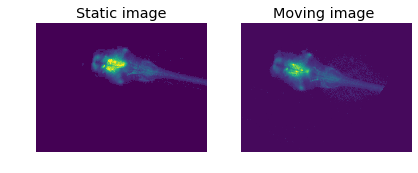

In [10]:
plot_two_images(static, transformed)


## 5c. Integration with Dipy

In [16]:
from scipy import optimize
affine_transform = RotationTransform2D()
metric.setup(affine_transform, static, moving,
                              None,
                              None, None)
initial = [np.rad2deg(1)]
# compute ssd
metric = SSDMetric()

In [17]:
affreg = AffineRegistration(metric=metric,
                            level_iters=None,
                            sigmas=None,ss_sigma_factor=1,
                            factors=None)

affine = affreg.optimize(static, moving, affine_transform, initial,
                              None, None,
                              starting_affine=None)


Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


In [18]:
transformed = affine.transform(moving)

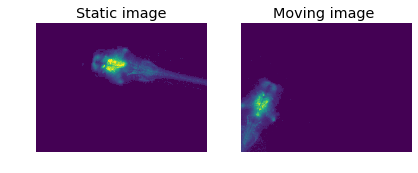

In [19]:
plot_two_images(static, transformed)